# Library & Install

In [1]:
!pip install Sastrawi

In [2]:
import re
import csv
import nltk
import string
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.svm import SVC
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

Insight:
### Instalasi Library yang Digunakan

Untuk menjalankan proyek ini, kamu perlu menginstal beberapa library terlebih dahulu. Salah satunya adalah **Sastrawi**, yang digunakan untuk stemming pada teks Bahasa Indonesia. Untuk menginstalnya, gunakan perintah berikut:

```bash
!pip install Sastrawi
```
Dan untuk library nya:
* `nltk` & `Sastrawi` : untuk preprocessing teks Bahasa Indonesia, termasuk tokenisasi, stopword removal, dan stemming dengan Sastrawi.
* `TfidfVectorizer` (dari Scikit-learn) : mengubah teks menjadi representasi numerik dengan metode TF-IDF untuk mengenali relevansi kata dalam teks.
* `SVC` (dari Scikit-learn) : untuk klasifikasi data, seperti klasifikasi sentimen. Mendukung kernel linear maupun non-linear seperti RBF untuk menangani data kompleks.
* `LogisticRegression` (Scikit-learn) : model klasifikasi dasar yg efisien dan sering digunakan sebagai baseline dalam klasifikasi teks.
* `SMOTE` (Imbalanced-learn) : teknik oversampling untuk menyeimbangkan jumlah data antar kelas, sangat membantu saat dataset tidak seimbang.
* `tensorflow.keras.models.Sequential` : untuk membangun model neural network berlapis secara bertahap (layer by layer).
* `Dense` & `Dropout` (Keras Layers) :
    - `Dense` : layer fully-connected dalam neural network.
    - `Dropout` : mencegah overfitting dengan mengabaikan sebagian neuron secara acak saat training.
* `LabelEncoder` & `to_categorical` : untuk mengubah label kategori menjadi format numerik atau one-hot encoding agar bisa digunakan oleh model.
* `train_test_split` : untuk membagi dataset menjadi data latih & uji untuk menghindari overfitting & mengukur performa model secara objektif.
* `matplotlib` & `seaborn` : untuk visualisasi data
* `wordcloud` : untuk membuat visualisasi awan kata untuk menampilkan kata - kata yang sering muncul dalam dataset.
* `sklearn.metrics` : untuk mengevaluasi performa model menggunakan metrik seperti akurasi, precision, recall, & F1-score.
* `re`, `string`, `nltk.tokenize`, `stopwords` : membersihkan teks dari karakter tak penting, memecah kalimat menjadi kata, serta membuang kata - kata umum yang tidak informatif.
* `requests`, `csv`, `StringIO` : mengambil dan memproses data, terutama dari file CSV atau dari URL.

# Load Dataset

In [3]:
df = pd.read_csv('ulasan_aplikasi_HOK.csv')

# menampilkan informasi data
print(f"Jumlah ulasan: {df.shape[0]} baris")
print(f"Jumlah kolom: {df.shape[1]} kolom")
df.head()

Jumlah ulasan: 12000 baris
Jumlah kolom: 4 kolom


,userName,Rating,Review,Tanggal
0,Pengguna Google,1,"Keseimbangan kekuatan di game ini buruk, tak p...",2025-03-25 22:33:56
1,Pengguna Google,1,Soal game ini udah bagus dari grafik dan syste...,2025-03-23 20:59:00
2,Pengguna Google,3,tolong developer match y di perbaiki pencarian...,2025-04-09 09:24:59
3,Pengguna Google,1,"Match Maching yg sangat buruk, menghubungkan k...",2025-03-27 09:59:20
4,Pengguna Google,1,Grafiknya bagus.. tapi ini game menyedihkan se...,2025-03-24 01:29:49


Insight:

*   dataset ini memiliki jumlah ulasan sebanyak `1.200` baris & terdiri dari `4` kolom
*   menampilkan 5 baris ulasan berdasarkan tanggal yg relevan (Maret – April 2025)
*   review berdasarkan 5 baris pertama itu negatif (rating rendah)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  12000 non-null  object
 1   Rating    12000 non-null  int64 
 2   Review    12000 non-null  object
 3   Tanggal   12000 non-null  object
dtypes: int64(1), object(3)
memory usage: 375.1+ KB


Insight:

*   Dataset terdiri dari 12.000 baris dan 4 kolom utama (userName, Rating, Review, Tanggal)
*   tidak mengandung nilai kosong



# Preprocessing Text

In [5]:
# cleaning text
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

# case folding
def casefoldingText(text):
    return text.lower()

# tokenisasi
def tokenizingText(text):
    return word_tokenize(text)

# filtering (hapus stopwords)
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords.update(stopwords.words('english'))
    tambahan_stopwords = ['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy']
    listStopwords.update(tambahan_stopwords)

    return [word for word in text if word not in listStopwords]

# stemming
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# mengubah list token jadi kalimat
def toSentence(list_words):
    return ' '.join(list_words)

Insight :

*   Kode ini digunakan buat ngebersihin dan nyiapin data teks sebelum dianalisis. Prosesnya udah cukup lengkap, mulai dari hapus karakter yang nggak penting, ubah ke huruf kecil, tokenisasi, buang stopwords (baik Bahasa Indonesia maupun Inggris), sampai stemming.

In [6]:
# kamus kata slang → kata baku
slangwords = {
    "abis": "habis",
    "wtb": "beli",
    "masi": "masih",
    "wts": "jual",
    "wtt": "tukar",
    "bgt": "banget",
    "maks": "maksimal",
    "gk": "nggak",
    "ga": "nggak",
    "ngga": "nggak",
    "tdk": "tidak",
    "tp": "tapi",
    "udh": "sudah",
    "blm": "belum",
    "krn": "karena",
    "dr": "dari",
    "sm": "sama",
    "lg": "lagi",
    "jg": "juga",
    "aja": "saja",
    "dgn": "dengan",
    "sy": "saya",
    "gw": "saya",
    "lu": "kamu",
    "lo": "kamu",
    "km": "kamu",
    "trs": "terus"
}

# mengganti kata slang dengan kata standar
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    return ' '.join(fixed_words)

Insight :

*   Fungsi ini mengganti kata slang dengan bentuk baku agar makna kata konsisten dan hasil analisis teks lebih akurat.

In [7]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Insight:

Kode ini mengunduh resource penting dari NLTK, yaitu `'punkt'` untuk tokenisasi, `'punkt_tab'` sebagai file pendukung internal untuk tokenizer `'punkt'`, dan `'stopwords'` untuk menghapus kata - kata umum yang tidak bermakna dalam teks.

In [8]:
clean_df = df.copy()
clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)
clean_df

,userName,Rating,Review,Tanggal,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,1,"Keseimbangan kekuatan di game ini buruk, tak p...",2025-03-25 22:33:56,Keseimbangan kekuatan di game ini buruk tak pe...,keseimbangan kekuatan di game ini buruk tak pe...,keseimbangan kekuatan di game ini buruk tak pe...,"[keseimbangan, kekuatan, di, game, ini, buruk,...","[keseimbangan, kekuatan, game, buruk, peduli, ...",keseimbangan kekuatan game buruk peduli level ...
1,Pengguna Google,1,Soal game ini udah bagus dari grafik dan syste...,2025-03-23 20:59:00,Soal game ini udah bagus dari grafik dan syste...,soal game ini udah bagus dari grafik dan syste...,soal game ini udah bagus dari grafik dan syste...,"[soal, game, ini, udah, bagus, dari, grafik, d...","[game, udah, bagus, grafik, system, matchmakin...",game udah bagus grafik system matchmaking prob...
2,Pengguna Google,3,tolong developer match y di perbaiki pencarian...,2025-04-09 09:24:59,tolong developer match y di perbaiki pencarian...,tolong developer match y di perbaiki pencarian...,tolong developer match y di perbaiki pencarian...,"[tolong, developer, match, y, di, perbaiki, pe...","[tolong, developer, match, perbaiki, pencarian...",tolong developer match perbaiki pencarian matc...
3,Pengguna Google,1,"Match Maching yg sangat buruk, menghubungkan k...",2025-03-27 09:59:20,Match Maching yg sangat buruk menghubungkan ke...,match maching yg sangat buruk menghubungkan ke...,match maching yg sangat buruk menghubungkan ke...,"[match, maching, yg, sangat, buruk, menghubung...","[match, maching, yg, buruk, menghubungkan, sin...",match maching yg buruk menghubungkan sinyal si...
4,Pengguna Google,1,Grafiknya bagus.. tapi ini game menyedihkan se...,2025-03-24 01:29:49,Grafiknya bagus tapi ini game menyedihkan seka...,grafiknya bagus tapi ini game menyedihkan seka...,grafiknya bagus tapi ini game menyedihkan seka...,"[grafiknya, bagus, tapi, ini, game, menyedihka...","[grafiknya, bagus, game, menyedihkan, sistem, ...",grafiknya bagus game menyedihkan sistem match ...
...,...,...,...,...,...,...,...,...,...,...
11995,Pengguna Google,5,Game paling asuuuu yang pernah dimainkan serin...,2025-01-17 04:45:13,Game paling asuuuu yang pernah dimainkan serin...,game paling asuuuu yang pernah dimainkan serin...,game paling asuuuu yang pernah dimainkan serin...,"[game, paling, asuuuu, yang, pernah, dimainkan...","[game, asuuuu, dimainkan, banned, akun, rankud...",game asuuuu dimainkan banned akun rankudah ged...
11996,Pengguna Google,1,jaringan bagus tapi ping merah terus tolong ma...,2025-02-16 11:19:13,jaringan bagus tapi ping merah terus tolong ma...,jaringan bagus tapi ping merah terus tolong ma...,jaringan bagus tapi ping merah terus tolong ma...,"[jaringan, bagus, tapi, ping, merah, terus, to...","[jaringan, bagus, ping, merah, tolong, main, k...",jaringan bagus ping merah tolong main kalah mu...
11997,Pengguna Google,1,"Game ampas!!!! Kebanyakan dark sistem di sini,...",2025-01-14 11:21:03,Game ampas Kebanyakan dark sistem di sini sama...,game ampas kebanyakan dark sistem di sini sama...,game ampas kebanyakan dark sistem di sini sama...,"[game, ampas, kebanyakan, dark, sistem, di, si...","[game, ampas, kebanyakan, dark, sistem, kayak,...",game ampas kebanyakan dark sistem kayak game s...
11998,Pengguna Google,5,Gamenya Uda baguss banggat cuman ada masalah s...,2025-03-09 10:42:53,Gamenya Uda baguss banggat cuman ada masalah s...,gamenya uda baguss banggat cuman ada masalah s...,gamenya uda baguss banggat cuman ada masalah s...,"[gamenya, uda, baguss, banggat, cuman, ada, ma...","[gamenya, uda, baguss, banggat, cuman, klau, m...",gamenya uda baguss banggat cuman klau main kna...


Insight:

*   Dataset telah berhasil diproses melalui beberapa tahap pembersihan teks mulai dari cleaning, case folding, normalisasi kata slang, tokenisasi, hingga penghapusan stopword. Hasil akhirnya disimpan dalam kolom text_akhir, yang berisi versi teks ulasan yang lebih bersih dan siap digunakan untuk analisis lanjutan seperti klasifikasi atau analisis sentimen.

# Pelabelan


In [9]:
# kamus kata positif (+)
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# kamus kata negatif (-)
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

Insight:

*   Kode ini memuat kamus kata positif dan negatif dari file .csv online untuk analisis sentimen berbasis lexicon, agar sistem bisa menilai kecenderungan sentimen suatu review berdasarkan skor kata-katanya.

In [10]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

# jumlah tiap label
print(clean_df['polarity'].value_counts())

polarity
positive    8429
negative    3026
neutral      545
Name: count, dtype: int64


Insight:

*   analisis sentimen berbasis lexicon menunjukkan bahwa mayoritas ulasan pengguna cenderung positif (`8429` ulasan), sementara ulasan negatif tercatat sebanyak (`3026` ulasan), dan sisanya netral (`545` ulasan).  Ini menunjukkan persepsi pengguna cenderung baik, meski masih ada keluhan yang perlu diperhatikan.


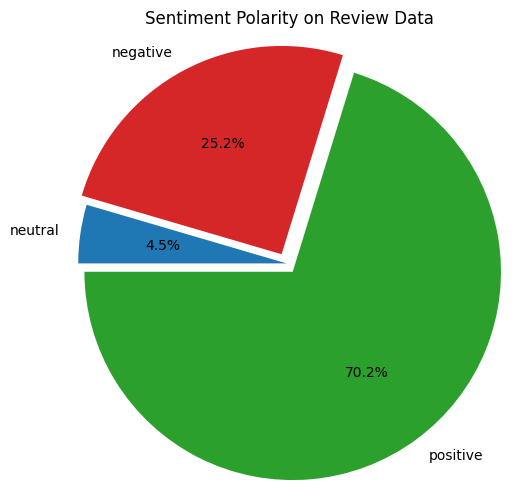

In [11]:
sentiment_counts = clean_df['polarity'].value_counts()

labels = ['positive', 'negative', 'neutral']
sizes = [sentiment_counts.get(label, 0) for label in labels]
colors = ['#2ca02c', '#d62728', '#1f77b4']

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=180,
    colors=colors,
    explode=(0.05, 0.05, 0)
)
plt.axis('equal')
plt.title('Sentiment Polarity on Review Data')
plt.show()


Insight:

*   `70.2%` ulasan bersifat positif, menunjukkan mayoritas pengguna merasa puas terhadap aplikasi/game yang ditinjau.
*   `25.2%` ulasan bersifat negatif, menandakan adanya sejumlah isu atau keluhan yang cukup signifikan dan perlu ditangani.
*   `4.5%` ulasan yang bersifat netral, yang berarti sebagian besar pengguna memiliki opini yang cukup jelas (baik atau buruk).

Kesimpulan: secara umum, sentimen pengguna cenderung positif, namun ulasan negatif yang cukup besar menunjukkan perlunya perbaikan di beberapa aspek untuk meningkatkan kepuasan pengguna secara menyeluruh.



# Eksplorasi Label

<ipython-input-12-a49a9e95f6f8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_labels, y=[sentiment_counts.get(label, 0) for label in ordered_labels], palette='Set2')


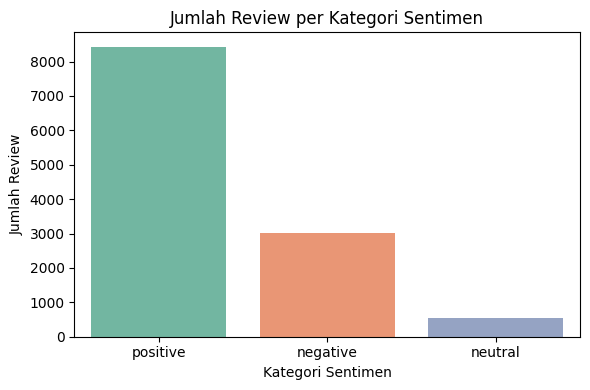

In [12]:
# bar chart
ordered_labels = ['positive', 'negative', 'neutral']

plt.figure(figsize=(6, 4))
# Replace 'label_counts' with 'sentiment_counts'
sns.barplot(x=ordered_labels, y=[sentiment_counts.get(label, 0) for label in ordered_labels], palette='Set2')
plt.title('Jumlah Review per Kategori Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

Insight:

*   **Review positif** mendominasi dengan jumlah lebih dari ` 8.429` ulasan, menandakan mayoritas pengguna memberikan tanggapan yang puas atau antusias terhadap aplikasi/game.
*   **Review negatif** berjumlah sekitar `3.026`, menunjukkan masih terdapat cukup banyak keluhan atau ketidakpuasan yang patut diperhatikan oleh pihak pengembang.
*   **Review netral** hanya sekitar `545`, yang berarti sebagian besar ulasan pengguna memiliki kecenderungan opini yang kuat, baik ke arah positif maupun negatif.

Kesimpulan: meskipun review positif mendominasi, proporsi review negatif yang cukup signifikan menunjukkan adanya ruang perbaikan. Pengembang sebaiknya menindaklanjuti ulasan negatif untuk meningkatkan kualitas dan pengalaman pengguna.

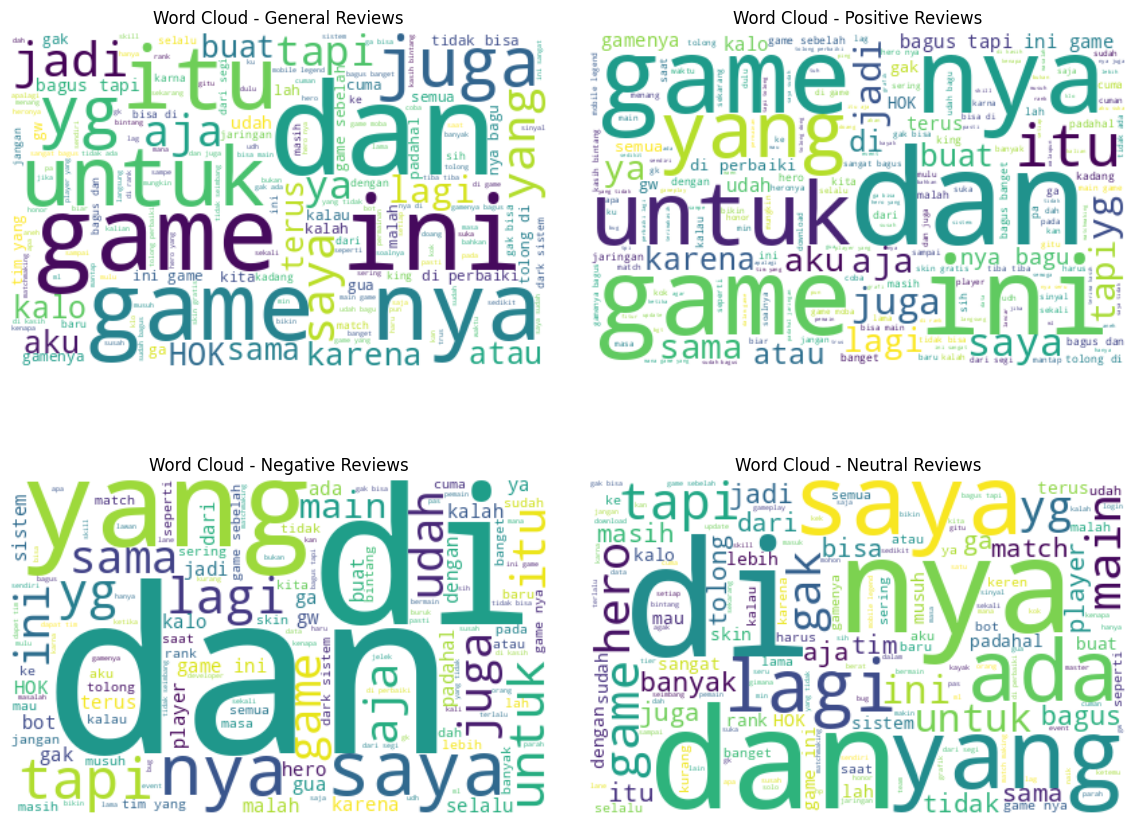

In [13]:
# word cloud
all_text = ' '.join(clean_df['Review'])
positive_text = ' '.join(clean_df[clean_df['polarity'] == 'positive']['Review'])
negative_text = ' '.join(clean_df[clean_df['polarity'] == 'negative']['Review'])
neutral_text = ' '.join(clean_df[clean_df['polarity'] == 'neutral']['Review'])
plt.figure(figsize=(12, 10))

# general
plt.subplot(2, 2, 1)
plt.imshow(WordCloud(width=400, height=250, background_color='white').generate(all_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - General Reviews', fontsize=12)

# positive
plt.subplot(2, 2, 2)
plt.imshow(WordCloud(width=400, height=250, background_color='white').generate(positive_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews', fontsize=12)

# negative
plt.subplot(2, 2, 3)
plt.imshow(WordCloud(width=400, height=250, background_color='white').generate(negative_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews', fontsize=12)

# neutral
plt.subplot(2, 2, 4)
plt.imshow(WordCloud(width=400, height=250, background_color='white').generate(neutral_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Neutral Reviews', fontsize=12)

plt.tight_layout(pad=3)
plt.show()

Insight:

*   `Positif`: Pengguna banyak memuji kualitas game, gameplay, dan fitur menarik seperti hero atau event.
*   `Negatif`: Keluhan terbanyak muncul pada masalah sinyal, lag, dan sistem matchmaking yang dianggap tidak adil.
*   `Netral`: Ulasan didominasi oleh kata-kata umum seperti “saya”, “main”, dan “yang” tanpa opini emosional yang jelas.
*   `General`: Kata **“game”** menjadi kata paling dominan di semua review, menunjukkan bahwa fokus utama pengguna tetap pada pengalaman bermain game itu sendiri.

# Data Splitting dan Ekstraksi Fitur dengan TF-IDF

In [19]:
X = clean_df['text_akhir']
y = clean_df['polarity']

# ekstraksi fitur pake TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# konversi hasil TF-IDF
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
print(features_df.head())

# bagi data menjadi data latih dan data uji (80:20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("Jumlah total data:", X.shape[0])
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

   acak   ad  adain  adakan  adil  admin  afk  aga   ah   ai  ...  wkwkwk  \
0   0.0  0.0    0.0     0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...     0.0   
1   0.0  0.0    0.0     0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...     0.0   
2   0.0  0.0    0.0     0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...     0.0   
3   0.0  0.0    0.0     0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...     0.0   
4   0.0  0.0    0.0     0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...     0.0   

   worth   wr  yaaa  yah        yg   yi  ying  yng  youtube  
0    0.0  0.0   0.0  0.0  0.093567  0.0   0.0  0.0      0.0  
1    0.0  0.0   0.0  0.0  0.000000  0.0   0.0  0.0      0.0  
2    0.0  0.0   0.0  0.0  0.000000  0.0   0.0  0.0      0.0  
3    0.0  0.0   0.0  0.0  0.118808  0.0   0.0  0.0      0.0  
4    0.0  0.0   0.0  0.0  0.179232  0.0   0.0  0.0      0.0  

[5 rows x 1344 columns]
Jumlah total data: 12000
Jumlah data latih: 9600
Jumlah data uji: 2400


Insight:

* **Ekstraksi Fitur** :Teks ulasan diubah menjadi representasi numerik menggunakan TF-IDF, menghasilkan `2.000` fitur berdasarkan kata-kata penting.
* **Penyaringan Kata** :Hanya kata-kata yang muncul minimal `17` kali dan tidak muncul di lebih dari `80%` review yang dipertahankan untuk menjaga kualitas fitur.
* **Pembagian Data** : Data dibagi menjadi `80%` latih (`9.600`) dan `20%` uji (`2.400`) untuk melatih dan menguji model secara adil.

# Modelling

## Skema 1

In [20]:
# TF-IDF: Resampling pakai SMOTE
smote = SMOTE(random_state=42)
X_tfidf_smote, y_smote = smote.fit_resample(X_tfidf, y)

# Split data 80/20
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf_smote, y_smote, test_size=0.2, random_state=42)

# Model SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_svm, y_train_svm)

# Prediksi
y_pred_svm = svm_model.predict(X_test_svm)

# Evaluasi
print("🔹 SVM + TF-IDF + SMOTE (80/20) 🔹")
print("Akurasi:", accuracy_score(y_test_svm, y_pred_svm))
print(classification_report(y_test_svm, y_pred_svm))

🔹 SVM + TF-IDF + SMOTE (80/20) 🔹
Akurasi: 0.9161724001581653
              precision    recall  f1-score   support

    negative       0.90      0.92      0.91      1646
     neutral       0.90      0.96      0.93      1698
    positive       0.95      0.88      0.91      1714

    accuracy                           0.92      5058
   macro avg       0.92      0.92      0.92      5058
weighted avg       0.92      0.92      0.92      5058



Model Algoritma ML SVM + TF-IDF + SMOTE menunjukkan performa baik dengan akurasi pada data uji `0.916`. Sentimen netral paling akurat dikenali dengan f1-score `0.93`, diikuti sentimen positif (`0.91`), sementara sentimen negatif memiliki performa sedikit lebih rendah dengan f1-score `0.91`.

## Skema 2

In [22]:
# TF-IDF: Resampling pakai SMOTE
smote = SMOTE(random_state=42)
X_tfidf_smote, y_smote = smote.fit_resample(X_tfidf, y)

# Split data 80/20
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf_smote, y_smote, test_size=0.2, random_state=42)

# Model Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_svm, y_train_svm)

# Prediksi
y_pred_logreg = logreg_model.predict(X_test_svm)

# Evaluasi
print("🔹 Logistic Regression + TF-IDF + SMOTE (80/20) 🔹")
print("Akurasi:", accuracy_score(y_test_svm, y_pred_logreg))
print(classification_report(y_test_svm, y_pred_logreg))

🔹 Logistic Regression + TF-IDF + SMOTE (80/20) 🔹
Akurasi: 0.8979833926453143
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      1646
     neutral       0.89      0.91      0.90      1698
    positive       0.92      0.87      0.90      1714

    accuracy                           0.90      5058
   macro avg       0.90      0.90      0.90      5058
weighted avg       0.90      0.90      0.90      5058



Insight :
* Model Logistic Regression + TF-IDF + SMOTE menunjukkan akurasi `0.898` pada data uji. Sentimen negatif dan netral memiliki f1-score `0.90`, sementara sentimen positif sedikit lebih rendah dengan f1-score `0.90`. Model ini berhasil mengklasifikasikan ketiga sentimen dengan baik.

## Skema 3

In [23]:
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc = to_categorical(le.transform(y_test))

# model Deep Learning
model_dl = Sequential()
model_dl.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_dl.add(Dropout(0.3))
model_dl.add(Dense(128, activation='relu'))
model_dl.add(Dropout(0.3))
model_dl.add(Dense(3, activation='softmax'))

# compile model
model_dl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training
history = model_dl.fit(X_train.toarray(), y_train_enc, epochs=15, batch_size=32,
                       validation_data=(X_test.toarray(), y_test_enc))

# evaluasi
loss, accuracy = model_dl.evaluate(X_test.toarray(), y_test_enc, verbose=0)
print(f"Akurasi Deep Learning (TF-IDF): {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7334 - loss: 0.6808 - val_accuracy: 0.8763 - val_loss: 0.3439
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8933 - loss: 0.2963 - val_accuracy: 0.8863 - val_loss: 0.3050
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9252 - loss: 0.2088 - val_accuracy: 0.8875 - val_loss: 0.3258
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9583 - loss: 0.1303 - val_accuracy: 0.8829 - val_loss: 0.3805
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9775 - loss: 0.0841 - val_accuracy: 0.8875 - val_loss: 0.4188
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9894 - loss: 0.0432 - val_accuracy: 0.8779 - val_loss: 0.4548
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9947 - loss: 0.0289 - val_accuracy: 0.8779 - val_loss: 0.4932
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9966 - loss: 0.0175 - val_accuracy: 

Insight:
* Model Deep Learning dengan TF-IDF menunjukkan akurasi pada data uji `0.873`. Meskipun model ini menunjukkan peningkatan akurasi yang signifikan selama pelatihan, performanya pada data uji sedikit menurun setelah beberapa epoch, dengan akurasi tertinggi mencapai `0.876`. Model ini mampu mengenali pola dalam data dengan baik, meskipun ada fluktuasi kecil dalam akurasi pada data uji.

In [29]:
# contoh input teks baru dari user
new_text = ["Permainannya sangat seru dan grafiknya keren!"]

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000, min_df=17, max_df=0.8)
text_vector = tfidf.transform(new_text)

# melakukan prediksi menggunakan model_dl yang sudah dilatih
predicted_probabilities = model_dl.predict(text_vector.toarray())
predicted_label = predicted_probabilities.argmax(axis=1)

# hasil prediksi
print(f"Teks: {new_text[0]}")

predicted_sentiment = le.inverse_transform(predicted_label)[0]
print(f"Prediksi Sentimen: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Teks: Permainannya sangat seru dan grafiknya keren!
Prediksi Sentimen: positive


Insight:

Model yang telah dilatih mampu melakukan prediksi sentimen pada teks baru secara akurat. Misalnya, pada input:

```bash
"Permainannya seru banget dan grafiknya keren!"
```

Model memprediksi:
```bash
Sentimen: positive
```

Hasil ini menunjukkan bahwa model dapat digunakan secara langsung untuk menganalisis ulasan pengguna secara real-time, menjadikannya alat yang aplikatif untuk memahami persepsi pengguna terhadap aplikasi.